### Forging ahead with Calculating $\delta T_L^x$ 

$ \alpha _L = \dfrac{(\dfrac{\delta q_{L.sat}^x}{q_{L.sat}^x})}{\delta T_L^x}  $      

$ \alpha _O = \dfrac{(\dfrac{\delta q_{O.sat}}{q_{O.sat}})}{\delta T_O} $

$ \alpha _L $ is the clausius clapeyron parameters defining the fractional sensitvities of land saturation specific humidities to a 1 K temperature change

Unlike before we know that O variables are going to be variable across percentile space


$\delta T_L^x = \gamma ^{T_O} \delta T_O$


$\gamma ^{T_O} = \dfrac{(c_p + L_v \alpha_O q_O)}{(c_p + L_v \alpha _L q_L^x)}$


In [1]:
import math
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import datetime
import os
import cftime
import matplotlib.pyplot as plt
from scipy import stats
import sys
import seaborn as sns
from scipy.stats import linregress, pearsonr, percentileofscore
sys.path.append('/home/users/chingosa/Functions/')
import CMIPFuncs as func
from multiprocessing import Pool, cpu_count
import time
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')
percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]


## Processing Model Data to calculate Gamma

In [2]:
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')
model = modelNames.ModelName[0]

def calc(model):
    tim = time.time()

    periods = ['historical', 'ssp245']
    variables = ['tas', 'huss', 'ps']
    percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]
    ## Grab the variables
    ds_hist, ds_ssp245 = func.dsRetrieve(variables, model, periods)
    
    # calculate q_sat
    ds_hist['q_sat'] = ((0.622*(0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds_hist['tas']))))) / ((ds_hist['ps']/1000) - ((0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds_hist['tas']))))*(1-0.622))))
    ds_ssp245['q_sat'] = ((0.622*(0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds_ssp245['tas']))))) / ((ds_ssp245['ps']/1000) - ((0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds_ssp245['tas']))))*(1-0.622))))
    
    ## Calculate MSE
    cp = 1004.6
    Lv = 2500000
    
    ds_hist['MSE'] = cp*ds_hist.tas + Lv*ds_hist.huss
    ds_ssp245['MSE'] = cp*ds_ssp245.tas + Lv*ds_ssp245.huss
    
    ### Land First
    for var in ['tas','huss', 'q_sat']:
        ds_hist[f'{var}_MOP_land'] = func.getMeansOverPercentile_difVar(ds_hist.tas.where(ds_hist.landseamask == 1), ds_hist[var].where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
        ds_ssp245[f'{var}_MOP_land'] = func.getMeansOverPercentile_difVar(ds_ssp245.tas.where(ds_ssp245.landseamask == 1), ds_ssp245[var].where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
    
    ### Ocean:
    
    ds_hist['MSE_MOP_land'] = func.getMeansOverPercentile_difVar(ds_hist.tas.where(ds_hist.landseamask == 1), ds_hist.MSE.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
    ds_ssp245['MSE_MOP_land'] = func.getMeansOverPercentile_difVar(ds_ssp245.tas.where(ds_hist.landseamask == 1), ds_ssp245.MSE.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
    
    
    ds_hist[f'MSE_land_px'] = xr.apply_ufunc(lambda x, y: percentileofscore(x.flatten(), y, nan_policy = 'omit'),
            ds_hist.MSE.where(ds_hist.landseamask == 1),
            ds_hist[f'MSE_MOP_land'],
    
        
            input_core_dims=[['time','lon'],[]],
            dask_gufunc_kwargs={
                'allow_rechunk': True
            },
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
        )
    
    ds_ssp245[f'MSE_land_px'] = xr.apply_ufunc(lambda x, y: percentileofscore(x.flatten(), y, nan_policy = 'omit'),
            ds_ssp245.MSE.where(ds_ssp245.landseamask == 1),
            ds_ssp245[f'MSE_MOP_land'],
    
        
            input_core_dims=[['time','lon'],[]],
            dask_gufunc_kwargs={
                'allow_rechunk': True
            },
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
        )
    
    for var in ['tas', 'q_sat', 'huss']:
        ds_hist[f'{var}_ocean_px'] = xr.apply_ufunc(lambda x, y: np.nanpercentile(x,y),
                                                          
                                                          ds_hist[var].where(ds_hist.landseamask == 0), 
                                                          ds_hist[f'MSE_land_px'],
                                                          input_core_dims=[['time','lon'],[]],
                                                          dask_gufunc_kwargs={
                                                              'allow_rechunk': True},
                                                          vectorize=True,
                                                          dask="parallelized",
                                                          output_dtypes=[float]
                                                         )
                
        ds_ssp245[f'{var}_ocean_px'] = xr.apply_ufunc(lambda x, y: np.nanpercentile(x,y),
                                                      
                                                      ds_ssp245[var].where(ds_ssp245.landseamask == 0), 
                                                      ds_hist[f'MSE_land_px'],
                                                      input_core_dims=[['time','lon'],[]],
                                                      dask_gufunc_kwargs={
                                                          'allow_rechunk': True},
                                                      vectorize=True,
                                                      dask="parallelized",
                                                      output_dtypes=[float]
                                                     )
    
    ds_ssp245 = ds_ssp245.drop_vars(['tas', 'huss', 'MSE', 'q_sat', 'ps', 'lat_bnds', 'lon_bnds', 'time_bnds', 'landseamask', 'lon', 'time'], errors='ignore')
    ds_hist = ds_hist.drop_vars(['tas', 'huss', 'MSE', 'q_sat', 'ps', 'lat_bnds', 'lon_bnds', 'time_bnds', 'landseamask', 'lon', 'time'], errors='ignore')
    
    ds_ssp245 = ds_ssp245.expand_dims(model = [model])
    ds_hist = ds_hist.expand_dims(model = [model])
    
    ds_ssp245.to_netcdf(f'ssp245_{model}_11_21.nc')
    ds_hist.to_netcdf(f'hist_{model}_11_21.nc')
    print(f'{model} is done in {time.time() -tim} seconds') 
    print('---------------------------------------------------------------------------------------')

for i, model in enumerate(modelNames.ModelName[2:]):

    print(f'{i+1}/18: {model}')
    calc(model)

1/18: BCC-CSM2-MR
BCC-CSM2-MR is done in 398.6533088684082 seconds
---------------------------------------------------------------------------------------
2/18: CanESM5
CanESM5 is done in 269.76881885528564 seconds
---------------------------------------------------------------------------------------
3/18: CESM2-WACCM


/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values

CESM2-WACCM is done in 692.3568279743195 seconds
---------------------------------------------------------------------------------------
4/18: CNRM-CM6-1
CNRM-CM6-1 is done in 575.5058953762054 seconds
---------------------------------------------------------------------------------------
5/18: CNRM-ESM2-1
CNRM-ESM2-1 is done in 590.6554174423218 seconds
---------------------------------------------------------------------------------------
6/18: GFDL-CM4
GFDL-CM4 is done in 759.6470003128052 seconds
---------------------------------------------------------------------------------------
7/18: GFDL-ESM4
GFDL-ESM4 is done in 682.0875885486603 seconds
---------------------------------------------------------------------------------------
8/18: HadGEM3-GC31-LL
HadGEM3-GC31-LL is done in 456.6384336948395 seconds
---------------------------------------------------------------------------------------
9/18: INM-CM4-8
INM-CM4-8 is done in 341.17510437965393 seconds
----------------------------

## Processing Model Data - mean across latitudes to cancel that part out

In [6]:
ds_all = xr.Dataset()
for model in (modelNames.ModelName):
    ds = xr.Dataset()

    ds_hist = xr.open_dataset(f'hist_{model}_11_21.nc')
    ds_ssp245 = xr.open_dataset(f'ssp245_{model}_11_21.nc')
    
    ds['d_q_sat_land'] = (ds_ssp245.q_sat_MOP_land - ds_hist.q_sat_MOP_land)
    ds['d_q_sat_ocean'] = (ds_ssp245.q_sat_ocean_px - ds_hist.q_sat_ocean_px)
    
    ds['d_tas_land'] = (ds_ssp245.tas_MOP_land - ds_hist.tas_MOP_land)
    ds['d_tas_ocean'] = (ds_ssp245.tas_ocean_px - ds_hist.tas_ocean_px)
    
    cp = 1004.6
    Lv = 2500000
    
    ds['alpha_L'] = ((ds.d_q_sat_land/ds_hist.q_sat_MOP_land) / ds.d_tas_land)
    
    ds['alpha_O'] = ((ds.d_q_sat_ocean/ds_hist.q_sat_ocean_px) / ds.d_tas_ocean)
    
    # alpha_L.mean('lat').plot()
    # alpha_O.mean('lat').plot()
    
    ds['gamma_top'] = (cp + (Lv*ds.alpha_O* ds_hist.huss_ocean_px))
    
    ds['gamma_bottom'] = (cp + (Lv*ds.alpha_L* ds_hist.huss_MOP_land))
    
    ds['gamma'] = ds.gamma_top/ds.gamma_bottom

    ds['d_px'] = (ds_ssp245.MSE_land_px - ds_hist.MSE_land_px)
    
    ds['d_tas_land_predict'] = (ds.gamma*ds.d_tas_ocean).weighted(ds_hist.landFracWeight * ds_hist.latWeight).mean('lat')
    ds['d_tas_land'] = (ds.d_tas_land).weighted(ds_hist.landFracWeight * ds_hist.latWeight).mean('lat')
    ds['d_tas_ocean'] = (ds.d_tas_ocean).weighted(ds_hist.oceanFracWeight * ds_hist.latWeight).mean('lat')
    ds['dfracland_ocean'] = ds['d_tas_land']/ds['d_tas_ocean']
    
    ds['gamma'] = (ds.gamma).weighted(ds_hist.landFracWeight * ds_hist.latWeight).mean('lat')
    
    ds = ds.drop_dims('height', errors='ignore')
    ds = ds.drop_vars('height', errors='ignore')
    ds_all = xr.merge([ds_all, ds])
    del ds
        
    # d_tas_land.mean('lat').plot(label = 'real')
    # plt.legend()
ds_all

<xarray.Dataset> Size: 9MB
Dimensions:             (model: 18, lat: 333, MOP: 26)
Coordinates:
  * model               (model) <U15 1kB 'ACCESS-CM2' ... 'UKESM1-0-LL'
  * lat                 (lat) float64 3kB -20.0 -19.89 -19.63 ... 19.89 20.0
  * MOP                 (MOP) float64 208B 0.001 1.0 5.0 10.0 ... 95.0 97.5 99.0
Data variables:
    d_q_sat_land        (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    d_q_sat_ocean       (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    d_tas_land          (model, MOP) float64 4kB 3.671 3.672 ... 5.054 5.121
    d_tas_ocean         (model, MOP) float64 4kB 2.408 2.406 ... 2.91 2.921
    alpha_L             (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    alpha_O             (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    gamma_top           (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    gamma_bottom        (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    gamma               (model, MOP) float64 4kB 1.241 1.24 ... 1.373 1.436
    d_px                (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    d_tas_land_predict  (model, MOP) float64 4kB 3.009 3.005 ... 4.02 4.216
    dfracland_ocean     (model, MOP) float64 4kB 1.525 1.526 ... 1.736 1.753

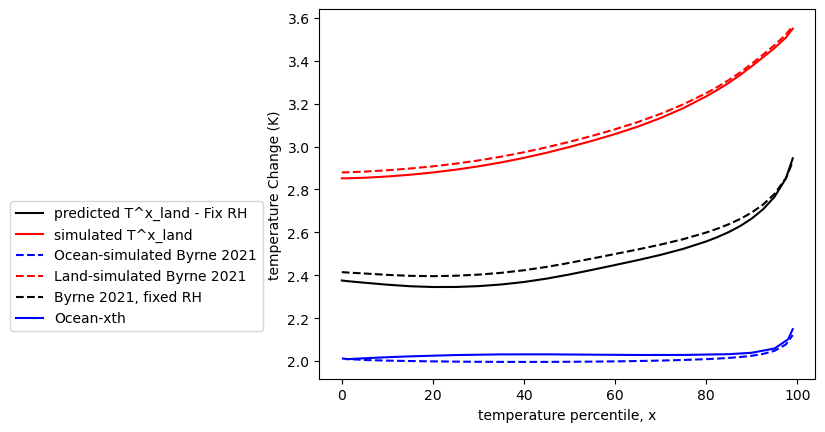

In [7]:

# ds_all.d_tas_land_predict.plot(hue = 'model')
ds_all.d_tas_land_predict.mean('model').plot(label = 'predicted T^x_land - Fix RH', color = 'k', linestyle = '-')
ds_all.d_tas_land.mean('model').plot(label = 'simulated T^x_land', c = 'r', ls = '-')
# ds_all.d_tas_ocean.mean('model').plot(label = 'ocean - px')
df_Byrne = pd.read_csv('41561_2021_828_MOESM4_ESM.csv')

df = pd.read_csv(f'percentileDifferences_all_flt.csv')
df_mean = df.groupby(['landOcean', 'percentile'], as_index = False).tChange.mean()
    
for i in [0,1]:
    plt.plot(df_Byrne['# Panel (a): X data'], df_Byrne[['Panel (a): Y data (solid blue line)', 'Panel (a): Y data (solid red line)'][i]], color = ['b', 'r'][i], label = ['Ocean-simulated Byrne 2021', 'Land-simulated Byrne 2021'][i], linestyle = '--')

plt.plot(df_Byrne['# Panel (a): X data'], df_Byrne['Panel (a): Y data (dotted black line)'], c = 'k', linestyle = '--', label = 'Byrne 2021, fixed RH')


for i in [0]:
    plt.plot(df_mean.percentile[df_mean['landOcean'] == i], df_mean.tChange[df_mean['landOcean'] == i], color = ['b', 'r'][i], label = ['Ocean-xth', 'Land-simulated'][i])

plt.legend(loc='best', bbox_to_anchor=(-0.6, 0., 0.5, 0.5))
plt.xlabel('temperature percentile, x')
plt.ylabel('temperature Change (K)')
plt.show()




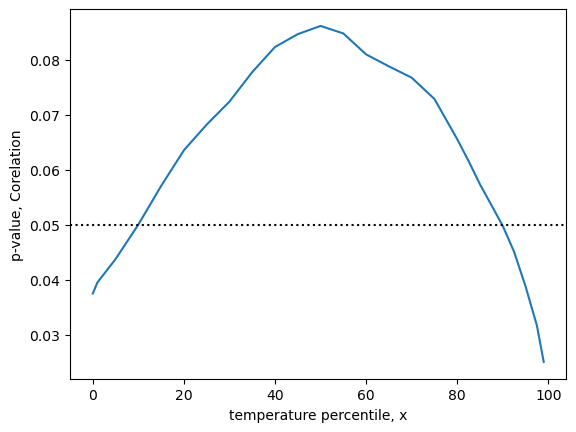

In [41]:
_, ds_all['p'] = pearsonr(ds_all.gamma, ds_all.d_tas_land)
plt.plot(ds_all.MOP, ds_all.p)
plt.axhline([0.05], c = 'k', ls = ':')
plt.xlabel('temperature percentile, x')
plt.ylabel('p-value, Corelation')
plt.show()

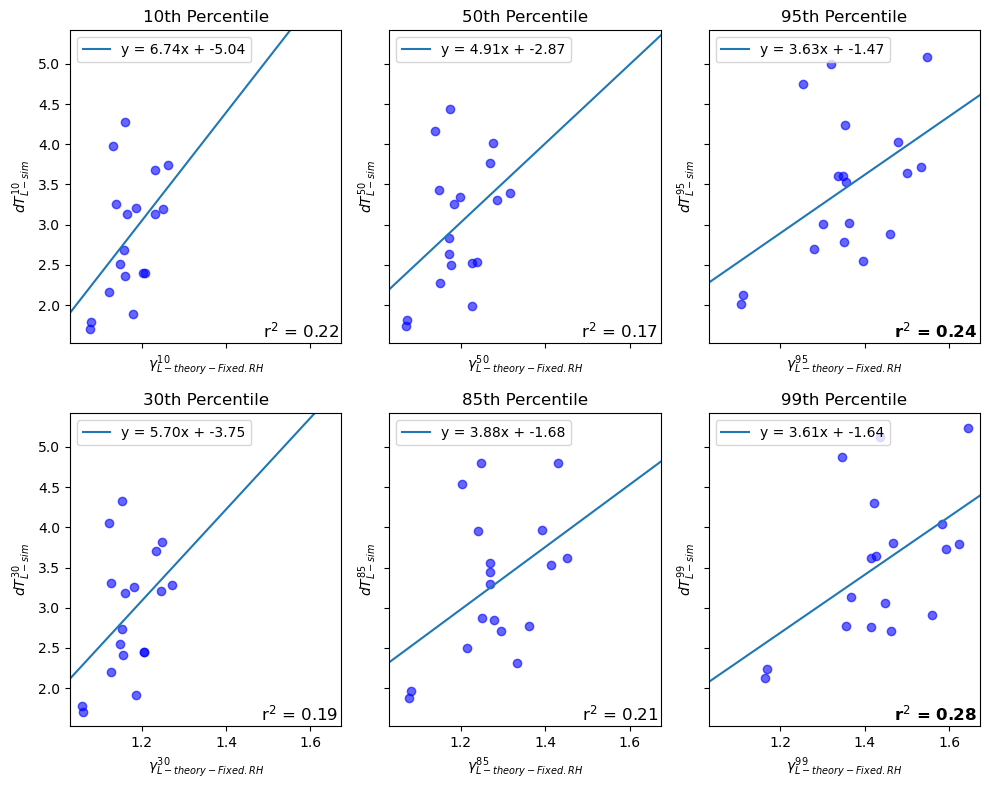

In [54]:
# Define percentiles to use for each subplot
percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]
percentiles = [10,30, 50, 85, 95, 99]
# Create a figure with 3 subplots
# fig, axes = plt.subplots(4, 7, figsize=(24, 15), sharex=True, sharey=True)
fig, axes = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

# Loop over each percentile and create a subplot
for i, percentile in enumerate(percentiles):
    # ax = axes[i%4, int(np.floor(i/4))]
    ax = axes[i%2, int(np.floor(i/2))]
    ds = ds_all.sel(MOP = percentile)

    # Scatter plot for the current percentile
    ax.scatter( ds.gamma, ds.d_tas_land, color='blue', alpha=0.6)

    # 1:1 Line (y=x)
    
    # ax.axline(( ds.gamma.mean(), ds.d_tas_land.mean()), slope=1, linestyle='--', label="1:1 Line", color='grey')

    # Line of best fit
    slope, intercept, _, _, _ = linregress(ds.gamma, ds.d_tas_land)
    ax.axline(xy1 = (ds.gamma.mean(),intercept + (slope*ds.gamma.mean())), slope = slope, label=f"y = {slope:.2f}x + {intercept:.2f}")


    # Correlation coefficient
    corr, p = pearsonr(ds.gamma, ds.d_tas_land)
    if p <0.05: weight ='bold'
    else: weight = 'normal'
    corr = corr**2

    ax.text(.99, .01, f"r$^2$ = {corr:.2f}", ha='right', va='bottom', transform=ax.transAxes, fontsize=12, weight = weight)
    # Set labels and title for each subplot
    ax.set_title(f"{percentile}th Percentile")
    ax.set_xlabel(f"$\gamma^{{{percentile}}}_{{L-theory - Fixed.RH}}$")
    ax.set_ylabel(f"$dT^{{{percentile}}}_{{L-sim}}$")
    
    # Add legend
    ax.legend(loc = 2)

# Adjust layout
plt.tight_layout()
plt.show()


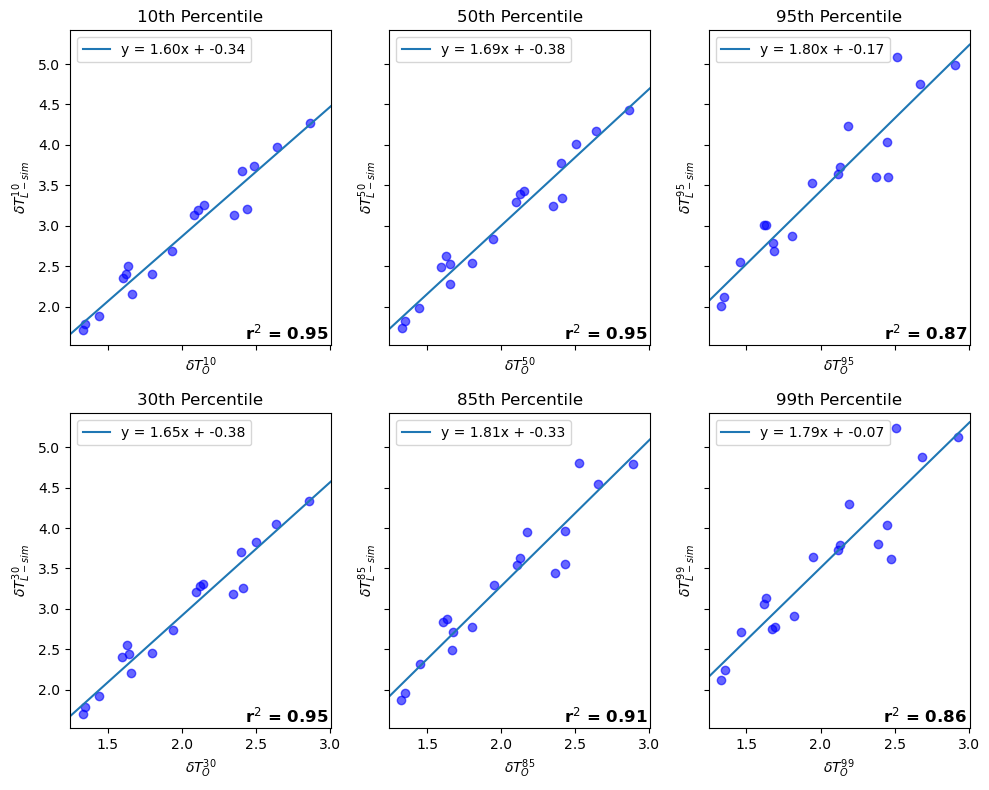

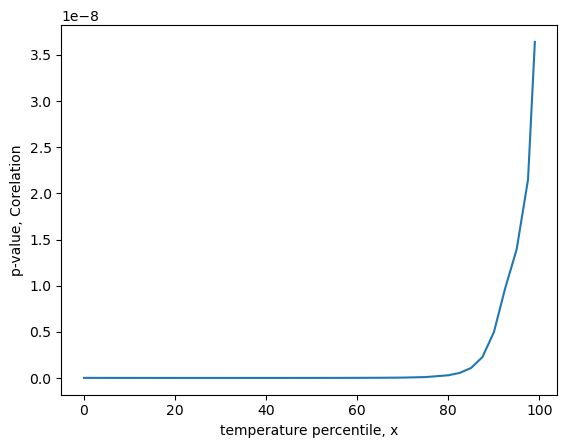

In [53]:
# Define percentiles to use for each subplot
percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]
percentiles = [10,30, 50, 85, 95, 99]
# Create a figure with 3 subplots
# fig, axes = plt.subplots(4, 7, figsize=(24, 15), sharex=True, sharey=True)
fig, axes = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

# Loop over each percentile and create a subplot
for i, percentile in enumerate(percentiles):
    # ax = axes[i%4, int(np.floor(i/4))]
    ax = axes[i%2, int(np.floor(i/2))]

    ds = ds_all.sel(MOP = percentile)

    x = ds.d_tas_ocean.values.flatten()
    y = ds.d_tas_land.values.flatten()
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]


    # Scatter plot for the current percentile
    ax.scatter( x, y, color='blue', alpha=0.6)

    # 1:1 Line (y=x)
    
    # ax.axline(( ds.gamma.mean(), ds.d_tas_land.mean()), slope=1, linestyle='--', label="1:1 Line", color='grey')

    # Line of best fit
    slope, intercept, _, _, _ = linregress( x, y,)
    ax.axline(xy1 = (x.mean(),intercept + (slope*x.mean())), slope = slope, label=f"y = {slope:.2f}x + {intercept:.2f}")


    # Correlation coefficient
    corr, p = pearsonr( x, y )
    if p <0.05: weight ='bold'
    else: weight = 'normal'
    corr = corr**2
    ax.text(.99, .01, f"r$^2$ = {corr:.2f}", ha='right', va='bottom', transform=ax.transAxes, fontsize=12, weight = weight)
    # Set labels and title for each subplot
    ax.set_title(f"{percentile}th Percentile")
    ax.set_xlabel(f"$\delta T^{{{percentile}}}_{{O}}$")
    ax.set_ylabel(f"$\delta T^{{{percentile}}}_{{L-sim}}$")
    
    # Add legend
    ax.legend(loc = 2)

# Adjust layout
plt.tight_layout()
plt.show()
_, ds_all['p'] = pearsonr(ds_all.d_tas_ocean, ds_all.d_tas_land)
plt.plot(ds_all.MOP, ds_all.p)
# plt.axhline([0.05], c = 'k', ls = ':')
plt.xlabel('temperature percentile, x')
plt.ylabel('p-value, Corelation')
plt.show()

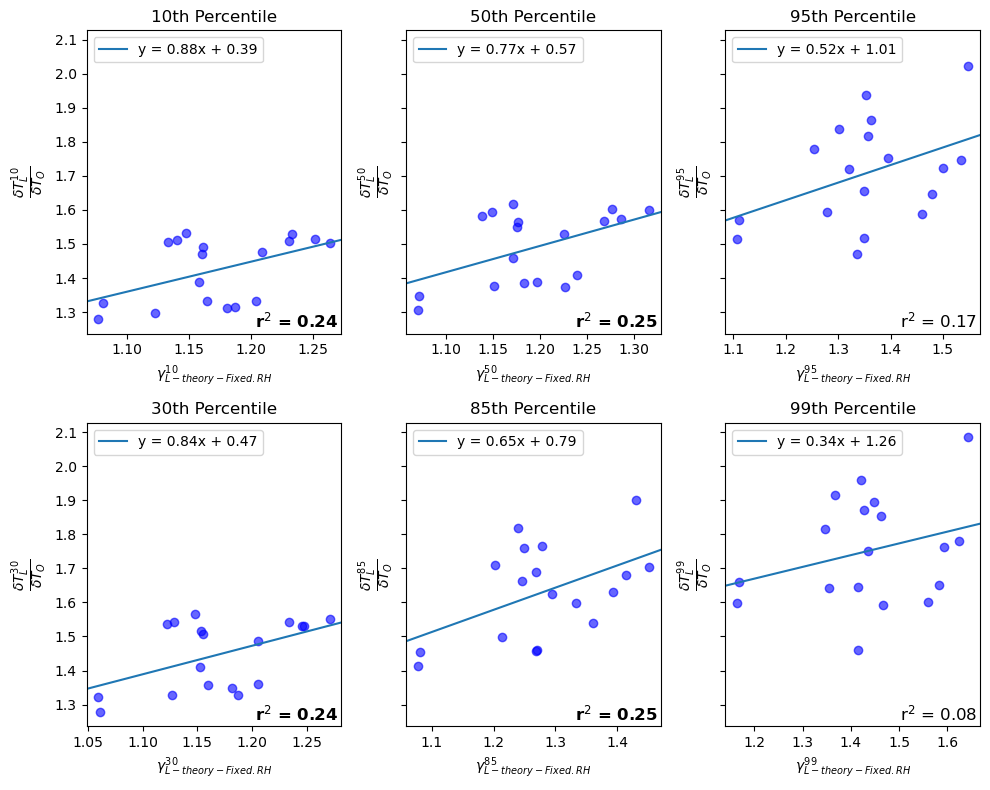

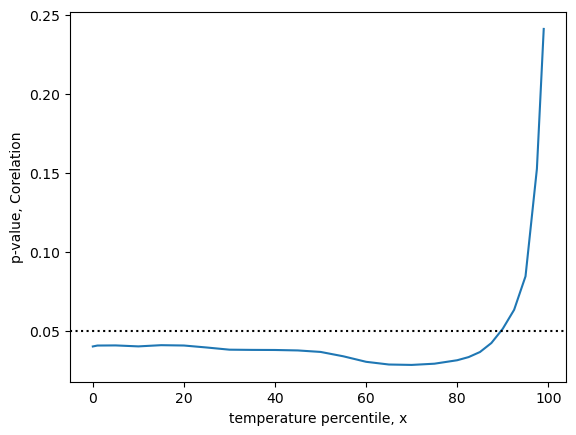

In [11]:
## This is looking at dtxl/dto

# Define percentiles to use for each subplot
percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]
percentiles = [10,30, 50, 85, 95, 99]
# Create a figure with 3 subplots
# fig, axes = plt.subplots(4, 7, figsize=(24, 15), sharex=True, sharey=True)
fig, axes = plt.subplots(2, 3, figsize=(10, 8), sharex=False, sharey=True)

# Loop over each percentile and create a subplot
for i, percentile in enumerate(percentiles):
    # ax = axes[i%4, int(np.floor(i/4))]
    ax = axes[i%2, int(np.floor(i/2))]
    ds = ds_all.sel(MOP = percentile)

    # Scatter plot for the current percentile
    ax.scatter( ds.gamma, ds.dfracland_ocean, color='blue', alpha=0.6)

    # 1:1 Line (y=x)
    

    # Line of best fit
    slope, intercept, _, _, _ = linregress(ds.gamma, ds.dfracland_ocean)
    ax.axline(xy1 = (ds.gamma.mean(),intercept + (slope*ds.gamma.mean())), slope = slope, label=f"y = {slope:.2f}x + {intercept:.2f}")


    # Correlation coefficient
    corr, p = pearsonr(ds.gamma, ds.dfracland_ocean)
    if p <0.05: weight ='bold'
    else: weight = 'normal'
    corr = corr**2

    ax.text(.99, .01, f"r$^2$ = {corr:.2f}", ha='right', va='bottom', transform=ax.transAxes, fontsize=12, weight = weight)
    # Set labels and title for each subplot
    ax.set_title(f"{percentile}th Percentile")
    ax.set_xlabel(f"$\gamma^{{{percentile}}}_{{L-theory - Fixed.RH}}$")
    ax.set_ylabel(f"$\dfrac{{\delta T^{{{percentile}}}_{{L}}}}{{\delta T_O}}$")
    
    # Add legend
    ax.legend(loc = 2)

# Adjust layout
plt.tight_layout()
plt.show()

_, ds_all['p'] = pearsonr(ds_all.gamma, ds_all.dfracland_ocean)
plt.plot(ds_all.MOP, ds_all.p)
plt.axhline([0.05], c = 'k', ls = ':')
plt.xlabel('temperature percentile, x')
plt.ylabel('p-value, Corelation')
plt.show()

In [12]:
ds_all = xr.Dataset()
for model in (modelNames.ModelName):
    ds = xr.Dataset()

    ds_hist = xr.open_dataset(f'hist_{model}_11_21.nc')
    ds_ssp245 = xr.open_dataset(f'ssp245_{model}_11_21.nc')
    
    ds['d_q_sat_land'] = (ds_ssp245.q_sat_MOP_land - ds_hist.q_sat_MOP_land)
    ds['d_q_sat_ocean'] = (ds_ssp245.q_sat_ocean_px - ds_hist.q_sat_ocean_px)
    
    ds['d_tas_land'] = (ds_ssp245.tas_MOP_land - ds_hist.tas_MOP_land)
    ds['d_tas_ocean'] = (ds_ssp245.tas_ocean_px - ds_hist.tas_ocean_px)
    
    cp = 1004.6
    Lv = 2500000
    
    ds['alpha_L'] = ((ds.d_q_sat_land/ds_hist.q_sat_MOP_land) / ds.d_tas_land)
    
    ds['alpha_O'] = ((ds.d_q_sat_ocean/ds_hist.q_sat_ocean_px) / ds.d_tas_ocean)
    
    # alpha_L.mean('lat').plot()
    # alpha_O.mean('lat').plot()
    
    ds['gamma_top'] = (cp + (Lv*ds.alpha_O* ds_hist.huss_ocean_px))
    
    ds['gamma_bottom'] = (cp + (Lv*ds.alpha_L* ds_hist.huss_MOP_land))
    
    ds['gamma'] = ds.gamma_top/ds.gamma_bottom

    ds['d_px'] = (ds_ssp245.MSE_land_px - ds_hist.MSE_land_px)
    
    ds['d_tas_land_predict'] = (ds.gamma*ds.d_tas_ocean)
    ds['d_tas_land'] = (ds.d_tas_land)
    ds['gamma'] = (ds.gamma)
    ds['dfracland_ocean'] = ds['d_tas_land']/ds['d_tas_ocean']

    ds = ds.drop_dims('height', errors='ignore')
    ds = ds.drop_vars('height', errors='ignore')
    ds_all = xr.merge([ds_all, ds])
    print
    del ds
        
    # d_tas_land.mean('lat').plot(label = 'real')
    # plt.legend()
ds_all

<xarray.Dataset> Size: 15MB
Dimensions:             (model: 18, lat: 333, MOP: 26)
Coordinates:
  * model               (model) <U15 1kB 'ACCESS-CM2' ... 'UKESM1-0-LL'
  * lat                 (lat) float64 3kB -20.0 -19.89 -19.63 ... 19.89 20.0
  * MOP                 (MOP) float64 208B 0.001 1.0 5.0 10.0 ... 95.0 97.5 99.0
Data variables:
    d_q_sat_land        (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    d_q_sat_ocean       (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    d_tas_land          (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    d_tas_ocean         (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    alpha_L             (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    alpha_O             (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    gamma_top           (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    gamma_bottom        (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    gamma               (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    d_px                (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    d_tas_land_predict  (model, lat, MOP) float64 1MB nan nan nan ... nan nan
    dfracland_ocean     (model, lat, MOP) float64 1MB nan nan nan ... nan nan

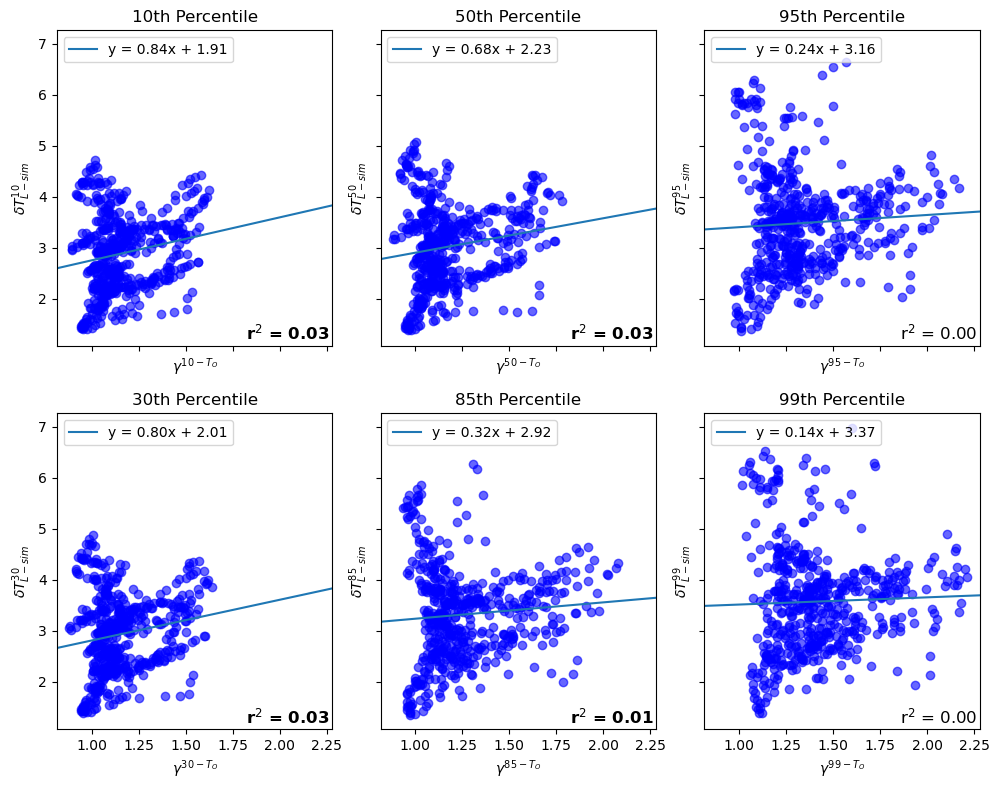

In [63]:
# Define percentiles to use for each subplot

percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]
percentiles = [10,30, 50, 85, 95, 99]
# Create a figure with 3 subplots
# fig, axes = plt.subplots(4, 7, figsize=(24, 15), sharex=True, sharey=True)
fig, axes = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

# Loop over each percentile and create a subplot
for i, percentile in enumerate(percentiles):
    ax = axes[i%2, int(np.floor(i/2))]
    ds = ds_all.sel(MOP = percentile)

    x = ds.gamma.values.flatten()
    y = ds.d_tas_land.values.flatten()
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]


    # Scatter plot for the current percentile
    ax.scatter( x, y, color='blue', alpha=0.6)

    # 1:1 Line (y=x)
    
    # ax.axline(( ds.gamma.mean(), ds.d_tas_land.mean()), slope=1, linestyle='--', label="1:1 Line", color='grey')

    # Line of best fit
    slope, intercept, _, _, _ = linregress( x, y)
    ax.axline(xy1 = (x.mean(),intercept + (slope*x.mean())), slope = slope, label=f"y = {slope:.2f}x + {intercept:.2f}")


    # Correlation coefficient
    corr, p = pearsonr( x, y )
    if p <0.05: weight ='bold'
    else: weight = 'normal'
    corr =corr**2
    ax.text(.99, .01, f"r$^2$ = {corr:.2f}", ha='right', va='bottom', transform=ax.transAxes, fontsize=12, weight = weight)
    # Set labels and title for each subplot
    ax.set_title(f"{percentile}th Percentile")
    ax.set_xlabel(f"$\gamma^{{{percentile} - T_O}}$")
    ax.set_ylabel(f"$\delta T^{{{percentile}}}_{{L-sim}}$")
    
    # Add legend
    ax.legend(loc = 2)

# Adjust layout
plt.tight_layout()
plt.show()



In [60]:
y

array([3.71893311, 3.71450806, 3.70016479, ..., 4.81103516, 4.87356567,
       4.89123535])

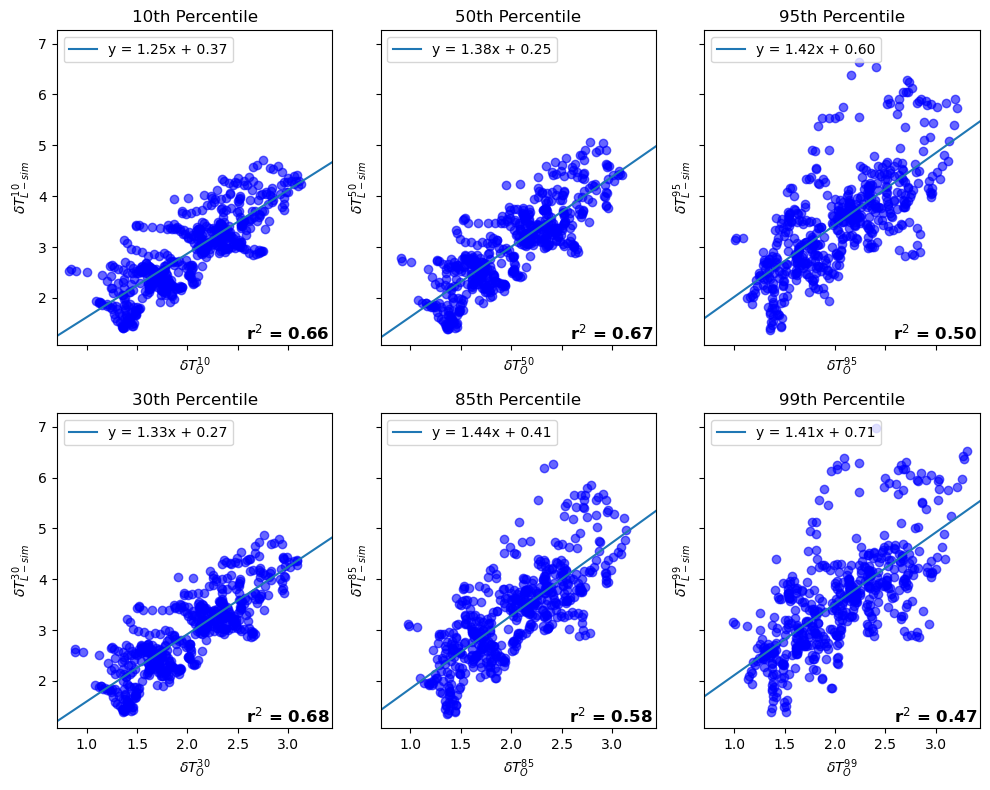

In [65]:
# Define percentiles to use for each subplot
percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]
percentiles = [10,30, 50, 85, 95, 99]
# Create a figure with 3 subplots
# fig, axes = plt.subplots(4, 7, figsize=(24, 15), sharex=True, sharey=True)
fig, axes = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

# Loop over each percentile and create a subplot
for i, percentile in enumerate(percentiles):
    # ax = axes[i%4, int(np.floor(i/4))]
    ax = axes[i%2, int(np.floor(i/2))]

    ds = ds_all.sel(MOP = percentile)

    x = ds.d_tas_ocean.values.flatten()
    y = ds.d_tas_land.values.flatten()
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]


    # Scatter plot for the current percentile
    ax.scatter( x, y, color='blue', alpha=0.6)

    # 1:1 Line (y=x)
    
    # ax.axline(( ds.gamma.mean(), ds.d_tas_land.mean()), slope=1, linestyle='--', label="1:1 Line", color='grey')

    # Line of best fit
    slope, intercept, _, _, _ = linregress( x, y,)
    ax.axline(xy1 = (x.mean(),intercept + (slope*x.mean())), slope = slope, label=f"y = {slope:.2f}x + {intercept:.2f}")


    # Correlation coefficient
    corr, p = pearsonr( x, y )
    if p <0.05: weight ='bold'
    else: weight = 'normal'
    corr = corr**2
    ax.text(.99, .01, f"r$^2$ = {corr:.2f}", ha='right', va='bottom', transform=ax.transAxes, fontsize=12, weight = weight)
    # Set labels and title for each subplot
    ax.set_title(f"{percentile}th Percentile")
    ax.set_xlabel(f"$\delta T^{{{percentile}}}_{{O}}$")
    ax.set_ylabel(f"$\delta T^{{{percentile}}}_{{L-sim}}$")
    
    # Add legend
    ax.legend(loc = 2)

# Adjust layout
plt.tight_layout()
plt.show()


Text(0, 0.5, 'p-value, Corelation')

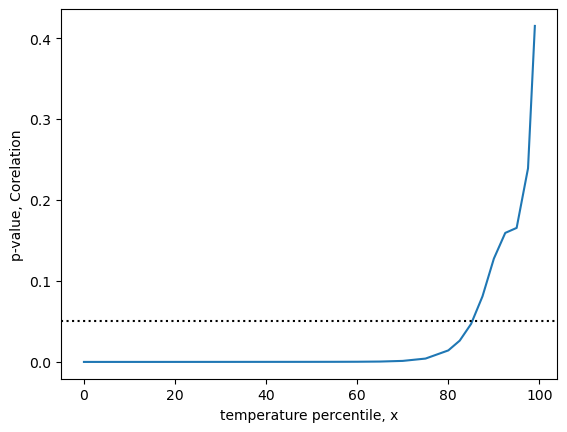

In [77]:
percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]
pList = []
for i, percentile in enumerate(percentiles):
    # ax = axes[i%4, int(np.floor(i/4))]
    ds = ds_all.sel(MOP = percentile)

    x = ds.gamma.values.flatten()
    y = ds.d_tas_land.values.flatten()
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    
    corr, p = pearsonr( x, y )
    if p <0.05: weight ='bold'
    else: weight = 'normal'
    corr = corr**2

    pList.append(p)
plt.plot(ds_all.MOP, pList)
plt.axhline([0.05], c = 'k', ls = ':')
plt.xlabel('temperature percentile, x')
plt.ylabel('p-value, Corelation')

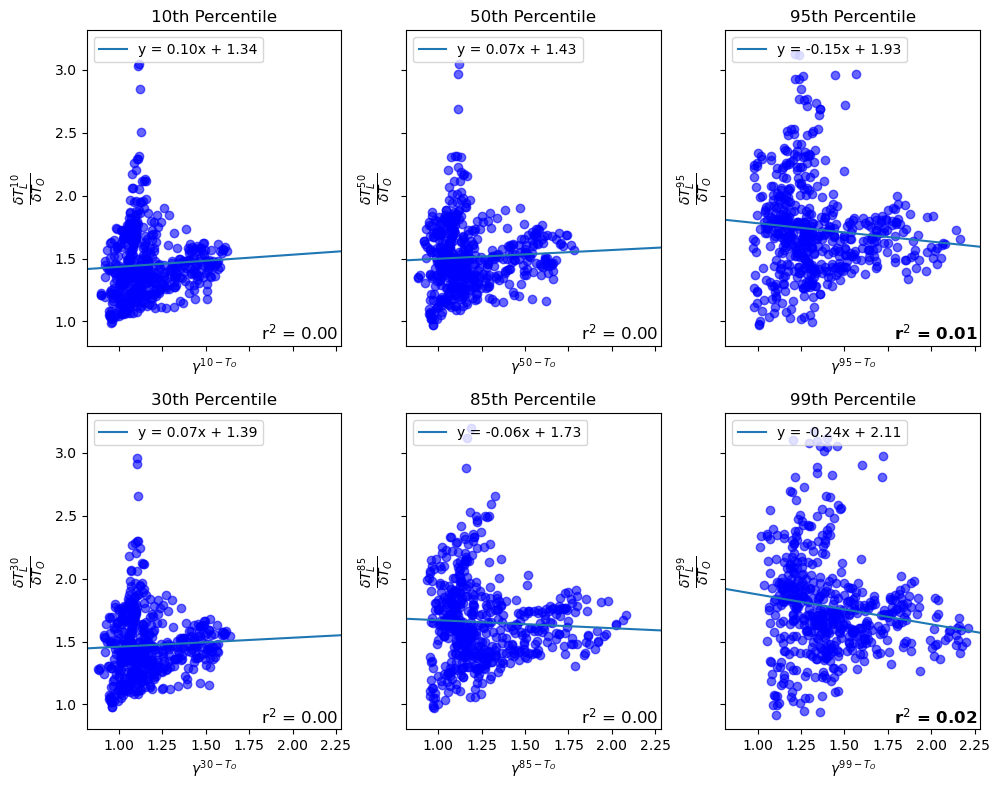

In [13]:
# Define percentiles to use for each subplot

percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]
percentiles = [10,30, 50, 85, 95, 99]
# Create a figure with 3 subplots
# fig, axes = plt.subplots(4, 7, figsize=(24, 15), sharex=True, sharey=True)
fig, axes = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

# Loop over each percentile and create a subplot
for i, percentile in enumerate(percentiles):
    ax = axes[i%2, int(np.floor(i/2))]
    ds = ds_all.sel(MOP = percentile)

    x = ds.gamma.values.flatten()
    y = ds.dfracland_ocean.values.flatten()
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]


    # Scatter plot for the current percentile
    ax.scatter( x, y, color='blue', alpha=0.6)

    # 1:1 Line (y=x)
    
    # ax.axline(( ds.gamma.mean(), ds.d_tas_land.mean()), slope=1, linestyle='--', label="1:1 Line", color='grey')

    # Line of best fit
    slope, intercept, _, _, _ = linregress( x, y)
    ax.axline(xy1 = (x.mean(),intercept + (slope*x.mean())), slope = slope, label=f"y = {slope:.2f}x + {intercept:.2f}")


    # Correlation coefficient
    corr, p = pearsonr( x, y )
    if p <0.05: weight ='bold'
    else: weight = 'normal'
    corr =corr**2
    ax.text(.99, .01, f"r$^2$ = {corr:.2f}", ha='right', va='bottom', transform=ax.transAxes, fontsize=12, weight = weight)
    # Set labels and title for each subplot
    ax.set_title(f"{percentile}th Percentile")
    ax.set_xlabel(f"$\gamma^{{{percentile} - T_O}}$")
    ax.set_ylabel(f"$\dfrac{{\delta T^{{{percentile}}}_{{L}}}}{{\delta T_O}}$")
    
    # Add legend
    ax.legend(loc = 2)

# Adjust layout
plt.tight_layout()
plt.show()



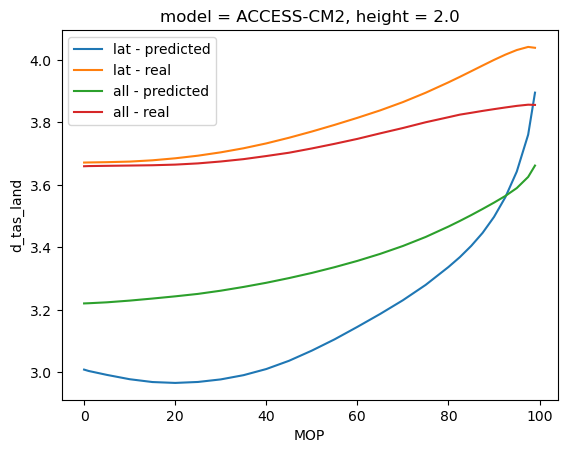

In [14]:
ds_all = xr.Dataset()
for model in ['ACCESS-CM2']:
    ds = xr.Dataset()

    ds_hist = xr.open_dataset(f'hist_{model}_11_21.nc')
    ds_ssp245 = xr.open_dataset(f'ssp245_{model}_11_21.nc')
    
    ds['d_q_sat_land'] = (ds_ssp245.q_sat_MOP_land - ds_hist.q_sat_MOP_land)
    ds['d_q_sat_ocean'] = (ds_ssp245.q_sat_ocean_px - ds_hist.q_sat_ocean_px)
    
    ds['d_tas_land'] = (ds_ssp245.tas_MOP_land - ds_hist.tas_MOP_land)
    ds['d_tas_ocean'] = (ds_ssp245.tas_ocean_px - ds_hist.tas_ocean_px)
    
    cp = 1004.6
    Lv = 2500000
    
    ds['alpha_L'] = ((ds.d_q_sat_land/ds_hist.q_sat_MOP_land) / ds.d_tas_land)
    
    ds['alpha_O'] = ((ds.d_q_sat_ocean/ds_hist.q_sat_ocean_px) / ds.d_tas_ocean)
    
    # alpha_L.mean('lat').plot()
    # alpha_O.mean('lat').plot()
    
    ds['gamma_top'] = (cp + (Lv*ds.alpha_O* ds_hist.huss_ocean_px))
    
    ds['gamma_bottom'] = (cp + (Lv*ds.alpha_L* ds_hist.huss_MOP_land))
    
    ds['gamma'] = ds.gamma_top/ds.gamma_bottom

    ds['d_px'] = (ds_ssp245.MSE_land_px - ds_hist.MSE_land_px)
    
    ds['d_tas_land_predict'] = (ds.gamma*ds.d_tas_ocean).weighted(ds_hist.landFracWeight * ds_hist.latWeight).mean('lat')
    ds['d_tas_land'] = (ds.d_tas_land).weighted(ds_hist.landFracWeight * ds_hist.latWeight).mean('lat')
    ds['d_tas_ocean'] = (ds.d_tas_ocean).weighted(ds_hist.oceanFracWeight * ds_hist.latWeight).mean('lat')
    ds['dfracland_ocean'] = ds['d_tas_land']/ds['d_tas_ocean']
    
    ds['gamma'] = (ds.gamma).weighted(ds_hist.landFracWeight * ds_hist.latWeight).mean('lat')
    
    ds = ds.drop_dims('height', errors='ignore')
    ds = ds.drop_vars('height', errors='ignore')
    ds_all = xr.merge([ds_all, ds])
    del ds
        
    # d_tas_land.mean('lat').plot(label = 'real')
    # plt.legend()
ds_all.d_tas_land_predict.plot(label = 'lat - predicted')
ds_all.d_tas_land.plot(label = 'lat - real')

#### Looking at stuff
ds = xr.open_dataset(f'{model}_11_22.nc')
ds.d_tas_land_predict.weighted(ds.landFracWeight * ds.latWeight).mean(['lat', 'lon']).plot(label = 'all - predicted')
ds.d_tas_land.weighted(ds.landFracWeight * ds.latWeight).mean(['lat', 'lon']).plot(label = 'all - real')
plt.legend()

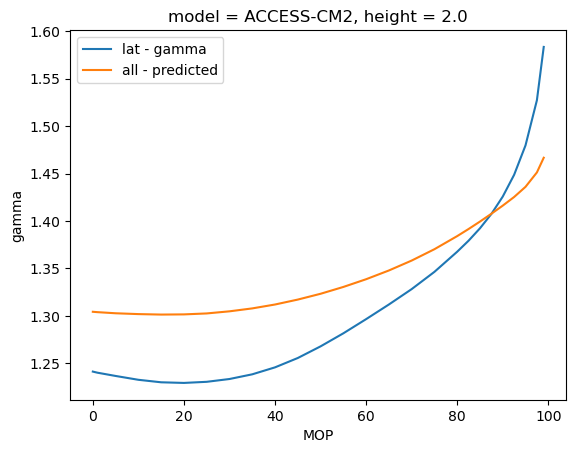

In [15]:
ds_all.gamma.plot(label = 'lat - gamma')

#### Looking at stuff
ds = xr.open_dataset(f'{model}_11_22.nc')
ds.gamma.weighted(ds.landFracWeight * ds.latWeight).mean(['lat', 'lon']).plot(label = 'all - predicted')
plt.legend()